In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns

import json
from datetime import datetime
from collections import Counter

In [2]:
colors=['#f2d138','#19bdff'] #majority/minority
greycolor='#626262'
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
##import survey data from Sparkman et al.
df = pd.read_csv(r'input/survey_data/participant_data.csv')

In [4]:
#create a copy of the dataframe to prevent altering the dataset
dfmedia=df.copy()

In [5]:
medialist=['CNN','NYT','ABC','NPR','FOX','Cons','Lib']

# add a column for each media category based on consuming once a week or more
dfmedia['CNN']=np.where((dfmedia["GRID_GTS3_1_GTS3"]>=3),True,False)
dfmedia['NYT']=np.where((dfmedia["GRID_GTS3_3_GTS3"]>=3),True,False)
dfmedia['ABC']=np.where((dfmedia["GRID_GTS3_4_GTS3"]>=3),True,False)
dfmedia['NPR']=np.where((dfmedia["GRID_GTS3_5_GTS3"]>=3),True,False)
dfmedia['FOX']=np.where((dfmedia["GRID_GTS3_6_GTS3"]>=3),True,False)
dfmedia['Cons']=np.where((dfmedia["GRID_GTS3_7_GTS3"]>=3),True,False)
dfmedia['Lib']=np.where((dfmedia["GRID_GTS3_8_GTS3"]>=3),True,False)




In [6]:
# convert ordinal variables to approximate number of days a month that they consume a given media channel
def weigh_by_freq(response):
    if response==1:
        return 0
    elif response==2:
        return 1 
    elif response==3:
        return 5
    elif response==4:
        return 15
    elif response==5:
        return 30
    else:
        return 0

#copy columns
alteredmedialist=['CNN_ord','','NYT_ord','ABC_ord','NPR_ord','FOX_ord','Cons_ord','Lib_ord'] #to account for skipping 2 in GTS3
for i in range(1,9):
    if i!=2:

        dfmedia[alteredmedialist[i-1]]=dfmedia["GRID_GTS3_"+str(i)+"_GTS3"]


ordinal_medialist=['CNN_ord','NYT_ord','ABC_ord','NPR_ord','FOX_ord','Cons_ord','Lib_ord']


for string in ordinal_medialist:
    dfmedia[string]=dfmedia[string].apply(weigh_by_freq)



In [7]:
#add a column for diversity of media consumption
dfmedia['number_of_outlets']=dfmedia[['CNN', 'NYT','ABC','NPR','FOX','Cons','Lib']].sum(axis=1)


In [8]:
synthetic_ratings=np.zeros(len(ordinal_medialist))
ratings_dict={}
for i in range(len(ordinal_medialist)):
    
    synthetic_ratings[i]=(dfmedia[ordinal_medialist[i]].sum())
    ratings_dict[medialist[i]]=synthetic_ratings[i]

print(ordinal_medialist)
print(synthetic_ratings)


['CNN_ord', 'NYT_ord', 'ABC_ord', 'NPR_ord', 'FOX_ord', 'Cons_ord', 'Lib_ord']
[46837. 30700. 80246. 24326. 32272. 18774. 12095.]


Text(0.5, 1.0, 'Estimated number of days per month the average survey responder consumes media (synthetic ratings)')

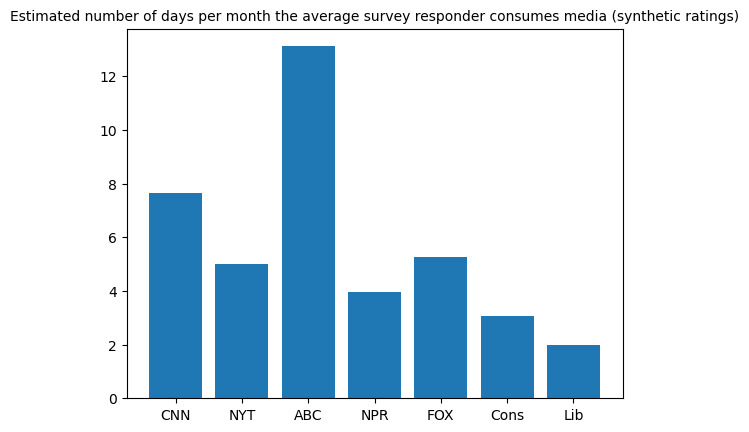

In [10]:
N=6119
plt.bar(medialist,synthetic_ratings/N)
plt.title('Estimated number of days per month the average survey responder consumes media (synthetic ratings)')

In [13]:

with open('input/Q1_counts.json', 'r') as json_file:
    Q1_counts = json.load(json_file)

with open('input/Q2_counts.json', 'r') as json_file:
    Q2_counts = json.load(json_file)

with open('input/Q3_counts.json', 'r') as json_file:
    Q3_counts = json.load(json_file)


In [14]:
Q1_counts={key: Q1_counts[key] for key in sorted(Q1_counts.keys())}
Q2_counts={key: Q2_counts[key] for key in sorted(Q2_counts.keys())}
Q3_counts={key: Q3_counts[key] for key in sorted(Q3_counts.keys())}

In [16]:
def combine_counts(counts_dict):
    """
    Combine counts from different categories into grouped totals.

    This function aggregates counts from a dictionary of arrays representing 
    different news outlets into broader categories: cable liberal, TV news, and Fox.

    Parameters:
    -----------
    counts_dict : dict
        A dictionary where keys are news outlet names (e.g., 'CNN', 'MSNBC', 'ABC', etc.) 
        and values are arrays representing counts for those outlets.

    Returns:
    --------
    dict
        A new dictionary with the following keys:
        - 'cable_lib': Combined counts for 'CNN' and 'MSNBC'.
        - 'tv_news': Combined counts for 'ABC', 'CBS', and 'NBC'.
        - 'Fox': Counts for 'Fox'.
    """
    # Initialize a new dictionary to store aggregated counts
    new_dict = {}

    # Combine counts for cable liberal news (CNN and MSNBC)
    new_dict['cable_lib'] = np.array(counts_dict['CNN']) + np.array(counts_dict['MSNBC'])

    # Combine counts for traditional TV news (ABC, CBS, NBC)
    new_dict['tv_news'] = (
        np.array(counts_dict['ABC']) + np.array(counts_dict['CBS']) + np.array(counts_dict['NBC'])
    )

    # Include counts for Fox without modification
    new_dict['Fox'] = np.array(counts_dict['Fox'])

    # Return the aggregated dictionary
    return new_dict


In [17]:
def compute_weighted_counts(combined_counts_dict, ratings_dict):
    """
    Compute weighted counts for grouped categories based on ratings.

    This function takes combined counts of categories (e.g., cable liberal, TV news, Fox) 
    and applies a weighting based on predefined ratings for specific news outlets.

    Parameters:
    -----------
    combined_counts_dict : dict
        A dictionary with keys 'cable_lib', 'tv_news', and 'Fox', where each value is 
        a list or array of counts representing the aggregated data for those categories.
    ratings_dict : dict
        A dictionary where keys are news outlet names (e.g., 'CNN', 'ABC', 'FOX'), and 
        values are numeric ratings used as weights for the counts.

    Returns:
    --------
    dict
        A new dictionary with the same keys as `combined_counts_dict`:
        - 'cable_lib': Weighted counts for the cable liberal category.
        - 'tv_news': Weighted counts for the TV news category.
        - 'Fox': Weighted counts for Fox.
    """
    # Initialize a new dictionary to store weighted counts
    new_dict = {}

    # Apply CNN ratings to cable_lib counts
    new_dict['cable_lib'] = [item * ratings_dict['CNN'] for item in combined_counts_dict['cable_lib']]

    # Apply ABC ratings to tv_news counts
    new_dict['tv_news'] = [item * ratings_dict['ABC'] for item in combined_counts_dict['tv_news']]

    # Apply FOX ratings to Fox counts
    new_dict['Fox'] = [item * ratings_dict['FOX'] for item in combined_counts_dict['Fox']]

    # Return the dictionary with weighted counts
    return new_dict


In [18]:
Q1_combined_counts_dict=combine_counts(Q1_counts)
Q1_weighted_counts=compute_weighted_counts(Q1_combined_counts_dict,ratings_dict)

Q2_combined_counts_dict=combine_counts(Q2_counts)
Q2_weighted_counts=compute_weighted_counts(Q2_combined_counts_dict,ratings_dict)

Q3_combined_counts_dict=combine_counts(Q3_counts)
Q3_weighted_counts=compute_weighted_counts(Q3_combined_counts_dict,ratings_dict)

In [19]:

Q1_choices=["Acknowledges","Neutral","Denies","Debate","Unclear"]
Q2_choices=["Expresses climate concern","Neutral","Expresses opposition to climate concern","Debate","Unclear"]
Q3_choices=["Supports","Neutral","Opposes","Debate","Unclear","No mention"]

short_Q2_choices=['Concern',
 'Neutral',
 'Opposition',
 'Debate',
 'Unclear']


In [20]:
Q3_weighted_counts

{'cable_lib': [11662413.0, 5573603.0, 327859.0, 468370.0, 39483591.0],
 'tv_news': [2728364.0, 1925904.0, 401230.0, 80246.0, 21104698.0],
 'Fox': [193632.0, 1194064.0, 3614464.0, 354992.0, 7422560.0]}

## Plotting

In [22]:
myblack='#222222'
    # Define color scheme
colors = ['#3879f2', '#f2b538', '#f24f38']  

In [23]:


def create_stacked_histogram(choices, weighted_counts, ax, title):
    """
    Create a stacked histogram on the provided axis.

    :param choices: List of choices for the x-axis.
    :param weighted_counts: Dictionary with keys as categories and values as counts.
    :param ax: Matplotlib axis object where the histogram will be drawn.
    :param title: Title of the histogram.
    """
    # Initialize the bottom position for stacking
    bottom = [0] * len(choices)
    total_heights = [0] * len(choices)
    bars = []

    # Plot each data series and collect the bar objects
    for key, values, color in zip(weighted_counts.keys(), weighted_counts.values(), colors):
        bar = ax.bar(choices, values, label=key, bottom=bottom, color=color)
        bars.append(bar[0])  # Store only one bar handle for the legend

        # Update the bottom position for the next series
        for i in range(len(values)):
            bottom[i] += values[i]
            total_heights[i] += values[i]

    # Adding labels and title
    ax.set_ylabel('Estimated views', color=myblack)
    ax.set_title(title,pad=20)

    # Rotate x-axis labels horizontally
    ax.tick_params(axis='x', labelrotation=45)
    
    # Set color of spines
    ax.spines['top'].set_color(myblack)
    ax.spines['right'].set_color(myblack)
    ax.spines['bottom'].set_color(myblack)
    ax.spines['left'].set_color(myblack)

    # Set color of ticks
    ax.tick_params(axis='x', colors=myblack)
    ax.tick_params(axis='y', colors=myblack)

    # Optional: to remove top and right spines
    sns.despine()

    return bars, total_heights


In [24]:
Q3_choices_no_unclear=Q3_choices[:-2]+Q3_choices[-1:]

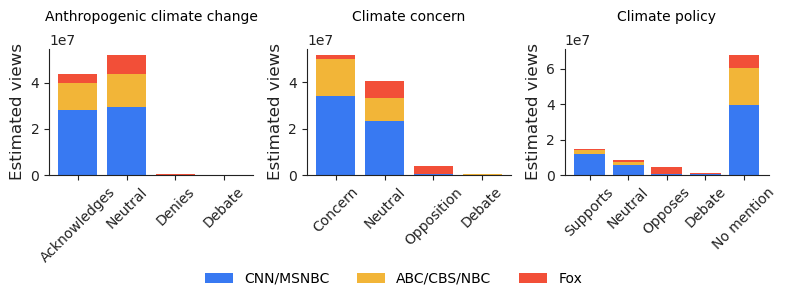

In [26]:
# Define a 1x3 figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

# Collect the bars from each histogram for the legend
Q1_bars, Q1_totals = create_stacked_histogram(Q1_choices[:-1], Q1_weighted_counts, axes[0], 'Anthropogenic climate change')
Q2_bars, Q2_totals = create_stacked_histogram(short_Q2_choices[:-1], Q2_weighted_counts, axes[1], 'Climate concern')
Q3_bars, Q3_totals = create_stacked_histogram(Q3_choices_no_unclear, Q3_weighted_counts, axes[2], 'Climate policy')

# Since the bars are the same for each category, we'll just use one set of bars and labels for the legend
bars = Q1_bars  # Use the bars from the first plot (same for all subplots)
labels = ['CNN/MSNBC', 'ABC/CBS/NBC', 'Fox']  # Labels corresponding to the categories

# Add a legend below all subplots
fig.legend(bars, labels, loc='lower center', ncol=len(labels), frameon=False)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust the layout to leave space for the legend
plt.savefig('99_figures/weighted_by_views.pdf')
# Show the plot
plt.show()
